In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
load_presaved_model = True
chosen_model = 'ResNet34'
local_mode = True

save_file = 'model.pt'

In [5]:
if local_mode: #on local pc
	save_path = 'Z://RR/Final/Saved_Models/'
	data_dir = 'Z://RR/Final/UTKFace/'
	
else:
	save_path = '/content/drive/MyDrive/Research/Models/'
	data_dir = '/content/drive/MyDrive/Research/UTKFace'
	
 
save_path = os.path.join(save_path,chosen_model)
full_save_file = os.path.join(save_path,save_file)

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transforms = {
    'train': transforms.Compose([ #compose several transforms together
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std) # normalize an image with mean and std
    ]),
}

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'train': 18961, 'val': 4747}

In [9]:
class_names

['0-2',
 '03-09',
 '10-19',
 '20-29',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 'more_than_70']

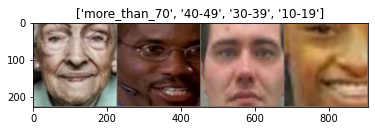

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

In [12]:
def load_checkpoint(model, optimizer, load_path):
	if torch.cuda.is_available():
		
		checkpoint = torch.load(load_path)
	else:
		checkpoint = torch.load(load_path,map_location=torch.device('cpu'))
		
	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
	epoch = checkpoint['epoch']

	return model, optimizer, epoch

In [13]:
def train_model(model, criterion, optimizer, scheduler,start_epoch, num_epochs=25):
	since = time.time()

	best_model_wts = copy.deepcopy(model.state_dict())
	best_acc = 0.0
 
	training_loss = []
	training_acc = []
 
	validation_loss = []
	validation_acc = []

	for epoch in range(start_epoch,num_epochs):
		print(f'Epoch {epoch}/{num_epochs - 1}')
		print('-' * 10)

		# Each epoch has a training and validation phase
		for phase in ['train', 'val']:
			if phase == 'train':
				model.train()  # Set model to training mode
			else:
				model.eval()   # Set model to evaluate mode

			running_loss = 0.0
			running_corrects = 0


			# Iterate over data.
			for inputs, labels in dataloaders[phase]:
				inputs = inputs.to(device)
				labels = labels.to(device)

				# zero the parameter gradients
				optimizer.zero_grad()

				# forward
				# track history if only in train
				with torch.set_grad_enabled(phase == 'train'):
					outputs = model(inputs)
					_, preds = torch.max(outputs, 1)
					loss = criterion(outputs, labels)

					# backward + optimize only if in training phase
					if phase == 'train':
						loss.backward()
						optimizer.step()

				# statistics
				running_loss += loss.item() * inputs.size(0)
				running_corrects += torch.sum(preds == labels.data)
			if phase == 'train':
				scheduler.step()

			epoch_loss = running_loss / dataset_sizes[phase]
			epoch_acc = running_corrects.double() / dataset_sizes[phase]

			print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
   
			if phase == 'train':
				training_loss.append(epoch_loss)
				training_acc.append(epoch_acc)
			else:
				validation_loss.append(epoch_loss)
				validation_acc.append(epoch_acc)

			# deep copy the model
			if phase == 'val' and epoch_acc > best_acc:
				best_acc = epoch_acc
				best_model_wts = copy.deepcopy(model.state_dict())

		print()

	time_elapsed = time.time() - since
	print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
	print(f'Best val Acc: {best_acc:4f}')

	# load best model weights
	model.load_state_dict(best_model_wts)
	return model,time_elapsed,training_loss,training_acc,validation_loss,validation_acc

Finetuning the convnet

Load a pretrained model and reset final fully connected layer.

In [15]:
weights = models.ResNet34_Weights.DEFAULT
model_ft = models.resnet34(weights = weights)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
starting_epoch = 0

if load_presaved_model :
  model_ft, optimizer, starting_epoch = load_checkpoint(model_ft, optimizer_ft, full_save_file)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 25

In [17]:
trained_model,time_elapsed,training_loss,training_acc,validation_loss,validation_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,starting_epoch,
                       num_epochs=num_epochs)

Epoch 16/24
----------


TODO: For now we do testing on the validations set, later we will need to create an independent testing set. 

In [27]:
def test_model(model, criterion, optimizer):
	# Iterate over data.
	running_loss = 0.0
	running_corrects = 0
	for inputs, labels in dataloaders['val']:
		inputs = inputs.to(device)
		labels = labels.to(device)

		# zero the parameter gradients
		optimizer.zero_grad()

		# forward
		# track history if only in train
		with torch.set_grad_enabled(False):
			outputs = model(inputs)
			_, preds = torch.max(outputs, 1)
			loss = criterion(outputs, labels)

		# statistics
		running_loss += loss.item() * inputs.size(0)
		running_corrects += torch.sum(preds == labels.data)

	loss = running_loss / dataset_sizes['val']
	acc = running_corrects.double() / dataset_sizes['val']
 
	return loss, acc

In [3]:
def write_results_drive(time_elapsed,training_loss,training_acc,validation_loss,validation_acc,path):
	
	with open(path,'w') as csvfile:
		fieldnames = ['epoch', 'train_loss','train_acc','val_loss','val_acc']
		writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
		writer.writeheader()
  
		for i in range(num_epochs):
			writer.writerow({'epoch':i, 'train_loss':training_loss[],'train_acc':training_acc[i],'val_loss':validation_loss[i],'val_acc':validation_acc[i]})
			


In [6]:
file = os.path.join(save_path,'results.csv')
write_results_drive(time_elapsed,training_loss,training_acc,validation_loss,validation_acc,file)